In [1]:
import csv
import numpy as np
from os import listdir
import rosbag
import matplotlib.pyplot as plt
import copy

In [2]:
food = {"grasshopper":["wheat"],"butterfly":["flower"],"fly":["apple"],
        "bird":["dragonfly","fly","wheat","grasshopper","apple"],
        "dragonfly":["butterfly","fly"],
        "frog":["grasshopper","butterfly","dragonfly","fly"],
        "eagle":["snake","mouse","frog","bird"], 
        "mouse":["wheat", "apple"],
        "wolf":["mouse","bird"],
        "snake":["mouse","frog","bird"]}
total_good = 0
for key, value in food.iteritems():
    total_good += len(value)
total_good

25

In [3]:
def analyse_file(path):
    with open(path, "rb") as f:
        reader = csv.reader(f)
        times_q = np.zeros(3)
        times_r = np.zeros(4)
        points = np.zeros(4)
        good = np.zeros(3)
        bad = np.zeros(3)
        for r in reader:
            if r[0] == "demo":
                try:
                    gender = r[1]
                except:
                    print "no gender provided"
                age = r[2]
            if r[0] == "Round1":
                times_r[0] =r[1]
                points[0] = r[2]
            if r[0] == "Round2":
                times_r[1] =r[1]
                points[1] = r[2]
            if r[0] == "Round3":
                times_r[2] =r[1]
                points[2] = r[2]
            if r[0] == "Round4":
                times_r[3] =r[1]
                points[3] = r[2]
            if r[0] == "pretest-time":
                times_q[0] = int(r[2])-int(r[1])
            if r[0] == "midtest-time":
                times_q[1] = int(r[2])-int(r[1])
            if r[0] == "posttest-time":
                times_q[2] = int(r[2])-int(r[1])
            if r[0] == "pretest":
                if r[2] in food[r[1]]:
                    good[0]+=1
                else:
                    bad[0]+=1
            if r[0] == "midtest":
                if r[2] in food[r[1]]:
                    good[1]+=1
                else:
                    bad[1]+=1
            if r[0] == "posttest":
                if r[2] in food[r[1]]:
                    good[2]+=1
                else:
                    bad[2]+=1
    return times_q, times_r, points, good, bad
        

In [4]:
def analyse_bag(path):
    bag = rosbag.Bag(path)
    i=-1
    counter_eat = np.zeros(4)
    counter_fail = np.zeros(4)
    for topic, msg, t in bag.read_messages(topics=['/sandtray/interaction_events']):
        s = msg.data
        if i>-1 and s.startswith("animaleats"):
            counter_eat[i]+=1
        if i>-1 and s.startswith("fail"):
            counter_fail[i]+=1
        if s.startswith("start"):
            i+=1
    return counter_eat, counter_fail

In [5]:
def analyse_folder(condition):
    filenames = listdir("../logs/"+condition)
    bag_filenames = listdir("../bags/"+condition)
    filenames.sort()
    n=len(filenames)
    times_q = np.zeros((n,3))
    times_r = np.zeros((n,4))
    points = np.zeros((n,4))
    eating = np.zeros((n,4))
    failing = np.zeros((n,4))
    good = np.zeros((n,3))
    bad = np.zeros((n,3))
    for i,f in enumerate(filenames):
        times_q[i], times_r[i], points[i], good[i], bad[i] = analyse_file("../logs/"+condition+"/"+f)
        eating[i],failing[i] = analyse_bag("../bags/"+condition+"/"+f.replace("csv","bag"))
        
    return times_q, times_r, points, good, bad, eating, failing

In [6]:
def print_results(tq, tr, p, g, b, e, f):
    print "Good"
    print g
    print "Bad"
    print b
    print "Time answering"
    print tq/60000.
    print "Time playing"
    print tr/60000.
    print "Points"
    print p
    print "Eating"
    print e
    print "Failing"
    print f

In [8]:
print "Results:"
print "Condition passive robot:"
p_tq, p_tr, p_po, p_g, p_b, p_e, p_f = analyse_folder("condition-nosparc-normal")
print_results(p_tq, p_tr, p_po, p_g, p_b, p_e, p_f)
print "Condition sparc robot:"
s_tq, s_tr, s_po, s_g, s_b, s_e, s_f = analyse_folder("condition-sparc-normal")
print_results(s_tq, s_tr, s_po, s_g, s_b, s_e, s_f)
p_p=p_g-p_b
p_l=p_p[:,2]-p_p[:,0]
p_l
s_p=s_g-s_b
s_l=s_p[:,2]-s_p[:,0]
s_l


Results:
Condition passive robot:
Good
[[ 3.  6.  5.]
 [ 3.  4.  4.]
 [ 3.  4.  6.]
 [ 2.  0.  0.]
 [ 8.  8.  9.]
 [ 1.  4.  6.]
 [ 5.  5.  7.]]
Bad
[[  2.   1.  10.]
 [  8.   6.   6.]
 [  3.   2.   1.]
 [  1.   0.   0.]
 [  3.   3.   2.]
 [  0.   0.   0.]
 [  2.   2.   2.]]
Time answering
[[ 5.81326667  1.20405     1.20415   ]
 [ 5.91041667  2.19371667  1.86488333]
 [ 5.6441      1.99015     1.54568333]
 [ 2.34488333  0.          0.        ]
 [ 4.19748333  2.02153333  2.44293333]
 [ 4.15665     0.81398333  0.78956667]
 [ 6.58656667  0.95816667  0.9637    ]]
Time playing
[[ 2.25056667  1.90018333  0.81766667  0.66948333]
 [ 1.70006667  1.17091667  1.94391667  1.85078333]
 [ 2.1822      2.25051667  1.71715     1.65615   ]
 [ 1.58378333  0.          0.          0.        ]
 [ 2.25013333  1.96025     2.13376667  2.24991667]
 [ 2.25028333  2.06235     2.24988333  1.76736667]
 [ 0.92915     0.54213333  0.56376667  1.40005   ]]
Points
[[ 932.5976875  865.753375   643.7281875  578.531    ]
 [

array([ 4., -2.,  7.,  6.,  3.,  6.])

In [12]:
def superplot(v):
    cat = v.shape[1]
    n = v.shape[0]
    p = plt.boxplot(v)
    offsets = np.linspace(.9,1.1,n)
    index = np.ones((cat, n))
    index = (index.T*np.arange(cat)).T+index*offsets
    plt.scatter(index.flatten(),v.T.flatten())
    plt.show()

In [28]:
a=[i for i in range(len(p_g)) if (i!=0 and i != 3)]
p_g=p_g[a]
p_b=p_b[a]
p_l=p_l[a]
p_f=p_f[a]
p_e=p_e[a]
p_po=p_po[a]

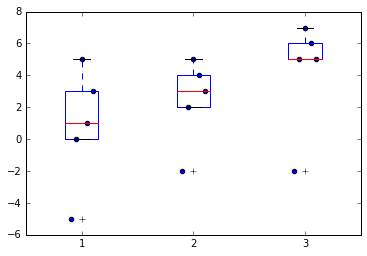

In [30]:
superplot(p_g-p_b)

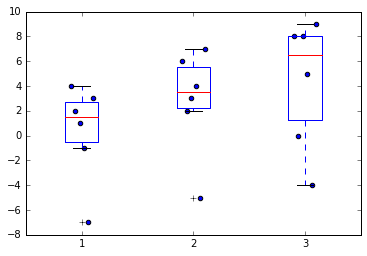

In [31]:
superplot(s_g-s_b)

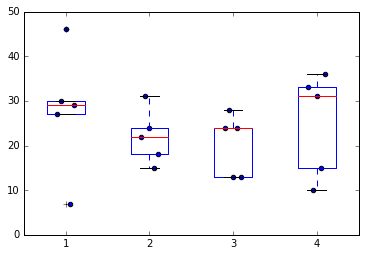

In [33]:
superplot(p_f)#-p_f[0:3,:])

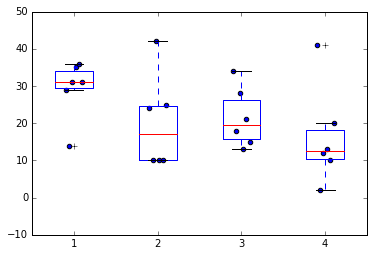

In [34]:
superplot(s_f)#-s_f)

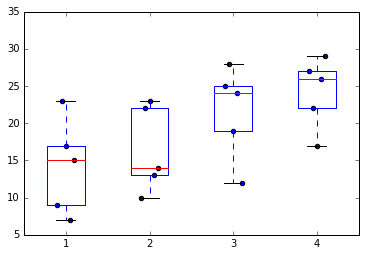

In [35]:
superplot(p_e)#-s_f)

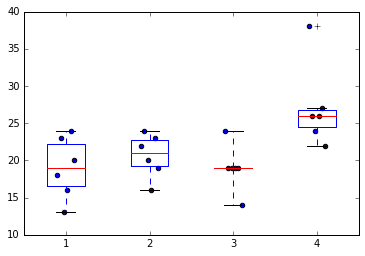

In [36]:
superplot(s_e)#-s_f)

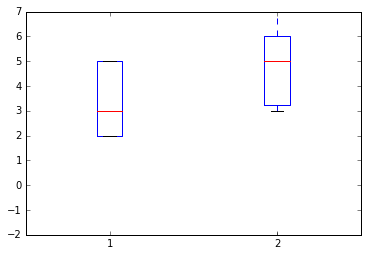

In [37]:
plt.boxplot([p_l,s_l])
plt.show()

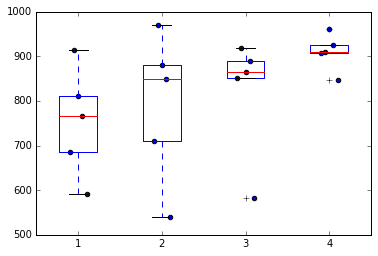

In [38]:
superplot(p_po)

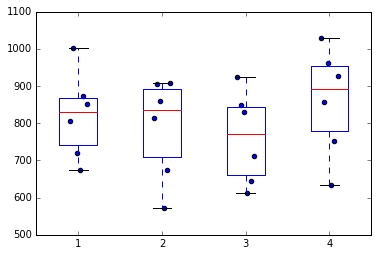

In [39]:
superplot(s_po)

In [50]:
#Learning:


In [40]:
def analyse_supervisor_file(path):
    with open(path, "rb") as f:
        reader = csv.reader(f)
        dictTemplate= {"proposed":[],"autoexe":[], "doit":[], "cancel":[], "skip":[], "select":[], "remove":[], "press":[], "enforced":[]}
        dicts=[copy.deepcopy(dictTemplate),copy.deepcopy(dictTemplate),copy.deepcopy(dictTemplate),copy.deepcopy(dictTemplate)]
        tStart=0
        roundNumber = 0
        proposed = False
        act = None
        pressed = False
        
        for r in reader:
            if pressed:
                if act == r[2]:
                    dicts[roundNumber]["enforced"].append((int(r[0])-tStart)/1000.)
                pressed = False
            if proposed:
                if r[1] == "press":
                    pressed = True
                proposed = False
            if r[1] == "proposed":
                proposed = True
                act = r[2]
            if r[1] == "start":
                tStart=int(r[0])
            elif r[1] == "endround":
                roundNumber+=1
            else:
                if roundNumber < 4:
                    dicts[roundNumber][r[1]].append((int(r[0])-tStart)/1000.)
    return dicts        

In [41]:
def analyse_supervisor():
    filenames = listdir("../supervisor/condition-sparc-normal")
    filenames.sort()
    n=len(filenames)
    d=[]
    for i,f in enumerate(filenames):
        temp = analyse_supervisor_file("../supervisor/condition-sparc-normal/"+f)
        for t in temp:
            d.append(t)
    return d

In [42]:
d = analyse_supervisor()

In [43]:
ratio=[]
for a in d:
    ratio.append(float(len(a["autoexe"])+len(a["enforced"])+len(a["doit"]))/len(a["proposed"]))

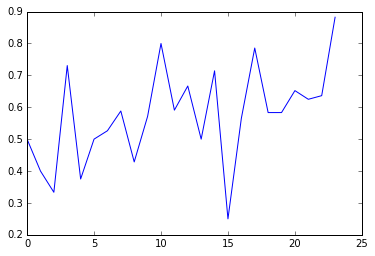

In [45]:
p=plt.plot(ratio)
plt.show()